## imports 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

#Scilearn-kit imports
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV

## Import the data

In [3]:
df_departments: pd.DataFrame = pd.read_csv('data/Departments.csv', encoding = "ISO-8859-1",sep=";")
df_stores: pd.DataFrame = pd.read_csv('data/stores.csv', encoding = "ISO-8859-1",sep=",")
df_features: pd.DataFrame = pd.read_csv('data/features.csv', encoding = "ISO-8859-1",sep=",")
df_holiday_dates: pd.DataFrame = pd.read_csv('data/Holiday Dates.csv', encoding = "ISO-8859-1",sep=";")
df_test: pd.DataFrame = pd.read_csv('data/test.csv', encoding = "ISO-8859-1",sep=",")
df_train: pd.DataFrame = pd.read_csv('data/train.csv', encoding = "ISO-8859-1",sep=",")

## Merge the datasets

In [4]:
# Change the date time format to %d-%m-%Y
df_features['Date'] = pd.to_datetime(df_features['Date'], format='%Y-%m-%d')
df_train['Date'] = pd.to_datetime(df_train['Date'], format='%Y-%m-%d')
df_test['Date'] = pd.to_datetime(df_test['Date'], format='%Y-%m-%d')
df_holiday_dates['Date'] = pd.to_datetime(df_holiday_dates['Date'], format='%d-%m-%Y')

# Merge all the dataframes into one
df: pd.DataFrame = df_train.merge(df_features, on=['Store', 'Date', 'IsHoliday'], how='left')
df = df.merge(df_stores, on=['Store'], how='left')
df = df.merge(df_departments, on=['Dept'], how='left')
df = df.merge(df_holiday_dates, on=['Date'], how='left')

# Fill the missing holiday name values with a '-'
df['HolidayNames'] = df['HolidayNames'].fillna('-')
df['Description'] = df['Description'].fillna('-')

# Fill in all the missing Markdown values with 0
df['MarkDown1'] = df['MarkDown1'].fillna(0)
df['MarkDown2'] = df['MarkDown2'].fillna(0)
df['MarkDown3'] = df['MarkDown3'].fillna(0)
df['MarkDown4'] = df['MarkDown4'].fillna(0)
df['MarkDown5'] = df['MarkDown5'].fillna(0)

# Fill all the unemployment and fuel price values with the average 
df['Unemployment'].fillna(df['Unemployment'].mean(), inplace=True)
df['Fuel_Price'].fillna(df['Fuel_Price'].mean(), inplace=True)

#Create a new column with the total markdown
df['Total_MarkDown'] = round(df['MarkDown1'] + df['MarkDown2'] + df['MarkDown3'] + df['MarkDown4'] + df['MarkDown5'], 2)

#Show the first 5 rows of the merged dataframe 
df.head()

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     1 2010-02-12      46039.49       True        38.51       2.548   
2      1     1 2010-02-19      41595.55      False        39.93       2.514   
3      1     1 2010-02-26      19403.54      False        46.63       2.561   
4      1     1 2010-03-05      21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        0.0        0.0        0.0        0.0        0.0  211.096358   
1        0.0        0.0        0.0        0.0        0.0  211.242170   
2        0.0        0.0        0.0        0.0        0.0  211.289143   
3        0.0        0.0        0.0        0.0        0.0  211.319643   
4        0.0        0.0        0.0        0.0        0.0  211.350143   

   Unemployment Type    Size        Description HolidayNames  Total_MarkDown  
0         8.106    A  151315  Candy and Tobacco            -             0.0  
1         8.106    A  151315  Candy and Tobacco    Superbowl             0.0  
2         8.106    A  151315  Candy and Tobacco            -             0.0  
3         8.106    A  151315  Candy and Tobacco            -             0.0  
4         8.106    A  151315  Candy and Tobacco            -             0.0

In [5]:
# Save the merged data
df.to_csv('Results/merged_data.csv', index=False)

## Find the outliers

In [6]:
# Print the description of the dataframe
df.describe()

Store           Dept                           Date  \
count  421570.000000  421570.000000                         421570   
mean       22.200546      44.260317  2011-06-18 08:30:31.963375104   
min         1.000000       1.000000            2010-02-05 00:00:00   
25%        11.000000      18.000000            2010-10-08 00:00:00   
50%        22.000000      37.000000            2011-06-17 00:00:00   
75%        33.000000      74.000000            2012-02-24 00:00:00   
max        45.000000      99.000000            2012-10-26 00:00:00   
std        12.785297      30.492054                            NaN   

        Weekly_Sales    Temperature     Fuel_Price      MarkDown1  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean    15981.258123      60.090059       3.361027    2590.074819   
min     -4988.940000      -2.060000       2.472000       0.000000   
25%      2079.650000      46.680000       2.933000       0.000000   
50%      7612.030000      62.090000       3.452000       0.000000   
75%     20205.852500      74.280000       3.738000    2809.050000   
max    693099.360000     100.140000       4.468000   88646.760000   
std     22711.183519      18.447931       0.458515    6052.385934   

           MarkDown2      MarkDown3      MarkDown4      MarkDown5  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean      879.974298     468.087665    1083.132268    1662.772385   
min      -265.760000     -29.100000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         2.200000       4.540000     425.290000    2168.040000   
max    104519.540000  141630.610000   67474.850000  108519.280000   
std      5084.538801    5528.873453    3894.529945    4207.629321   

                 CPI   Unemployment           Size  Total_MarkDown  
count  421570.000000  421570.000000  421570.000000   421570.000000  
mean      171.201947       7.960289  136727.915739     6684.041435  
min       126.064000       3.879000   34875.000000        0.000000  
25%       132.022667       6.891000   93638.000000        0.000000  
50%       182.318780       7.866000  140167.000000        0.000000  
75%       212.416993       8.572000  202505.000000     8075.260000  
max       227.232807      14.313000  219622.000000   160510.610000  
std        39.159276       1.863296   60980.583328    14750.941551

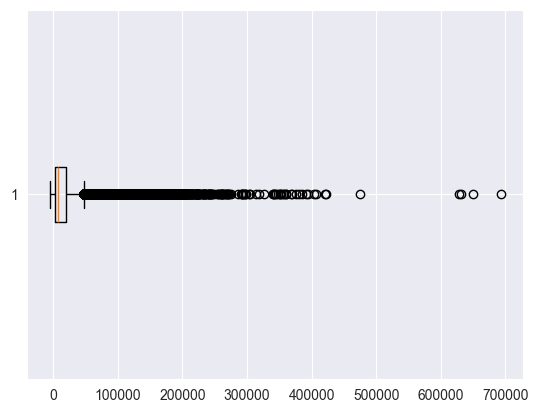

In [7]:
# Visualize the outliers via a boxplot
plt.boxplot(df['Weekly_Sales'], vert=False)
plt.show()

In [8]:
# Remove the outliers with the Z-Score methode
z_scores: np.ndarray = np.abs(stats.zscore(df['Weekly_Sales']))

# Define a threshold to identify the outliers
threshold: int = 3
outlier_mask = (z_scores <= threshold)
df_no_outliers = df[outlier_mask]

# Show the first five rows
df_no_outliers.head()

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     1 2010-02-12      46039.49       True        38.51       2.548   
2      1     1 2010-02-19      41595.55      False        39.93       2.514   
3      1     1 2010-02-26      19403.54      False        46.63       2.561   
4      1     1 2010-03-05      21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        0.0        0.0        0.0        0.0        0.0  211.096358   
1        0.0        0.0        0.0        0.0        0.0  211.242170   
2        0.0        0.0        0.0        0.0        0.0  211.289143   
3        0.0        0.0        0.0        0.0        0.0  211.319643   
4        0.0        0.0        0.0        0.0        0.0  211.350143   

   Unemployment Type    Size        Description HolidayNames  Total_MarkDown  
0         8.106    A  151315  Candy and Tobacco            -             0.0  
1         8.106    A  151315  Candy and Tobacco    Superbowl             0.0  
2         8.106    A  151315  Candy and Tobacco            -             0.0  
3         8.106    A  151315  Candy and Tobacco            -             0.0  
4         8.106    A  151315  Candy and Tobacco            -             0.0

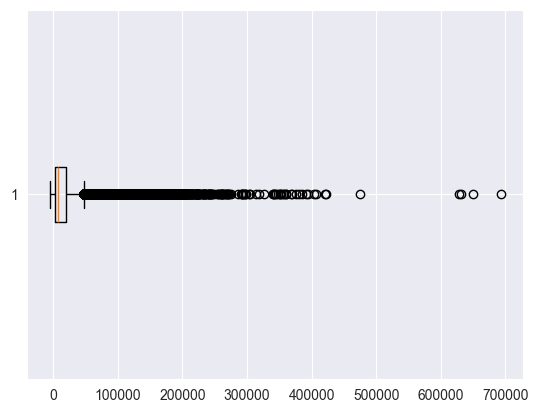

In [9]:
# Visualize the outliers via a boxplot
plt.boxplot(df['Weekly_Sales'], vert=False)
plt.show()

In [10]:
# Remove outliers with IQR method
# Calculate quartiles and IQR
Q1 = df['Weekly_Sales'].quantile(0.25)
Q3 = df['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a boolean mask to select non-outliers
outlier_mask = (df['Total_MarkDown'] >= lower_bound) & (df['Total_MarkDown'] <= upper_bound)

# Filter the DataFrame to keep only non-outliers
df_no_outliers = df[outlier_mask]

# Show the first five rows of the DataFrame without outliers
df_no_outliers.head()

Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     1 2010-02-12      46039.49       True        38.51       2.548   
2      1     1 2010-02-19      41595.55      False        39.93       2.514   
3      1     1 2010-02-26      19403.54      False        46.63       2.561   
4      1     1 2010-03-05      21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        0.0        0.0        0.0        0.0        0.0  211.096358   
1        0.0        0.0        0.0        0.0        0.0  211.242170   
2        0.0        0.0        0.0        0.0        0.0  211.289143   
3        0.0        0.0        0.0        0.0        0.0  211.319643   
4        0.0        0.0        0.0        0.0        0.0  211.350143   

   Unemployment Type    Size        Description HolidayNames  Total_MarkDown  
0         8.106    A  151315  Candy and Tobacco            -             0.0  
1         8.106    A  151315  Candy and Tobacco    Superbowl             0.0  
2         8.106    A  151315  Candy and Tobacco            -             0.0  
3         8.106    A  151315  Candy and Tobacco            -             0.0  
4         8.106    A  151315  Candy and Tobacco            -             0.0

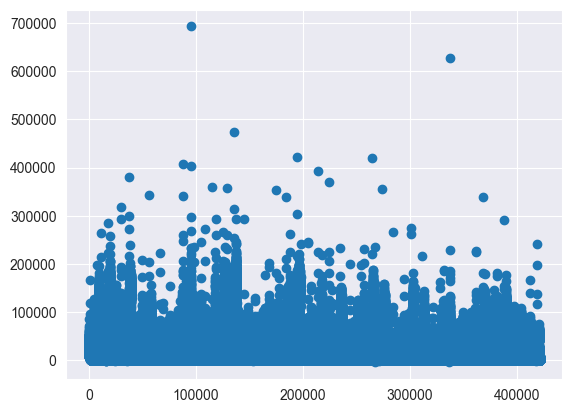

In [11]:
# Vizualize with a scatterplot
plt.scatter(df_no_outliers.index, df_no_outliers['Weekly_Sales'])
plt.show()

In [12]:
# set the Dataframe df equal to df_no_outliers
df = df_no_outliers

## Feature engineering

In [13]:
# Check if there is ant data missing
missing_values = df.isnull().sum()
print(f"\n\nmissing data : \n{missing_values}")



missing data : 
Store             0
Dept              0
Date              0
Weekly_Sales      0
IsHoliday         0
Temperature       0
Fuel_Price        0
MarkDown1         0
MarkDown2         0
MarkDown3         0
MarkDown4         0
MarkDown5         0
CPI               0
Unemployment      0
Type              0
Size              0
Description       0
HolidayNames      0
Total_MarkDown    0
dtype: int64


In [14]:
# Assign a StoreType based on the sales (top 25& = Type A, 26-74 is Type B and the bottom 25% is type C)
# Calculate the quartiles for weekly_sales
Q1 = df['Weekly_Sales'].quantile(0.25)
Q3 = df['Weekly_Sales'].quantile(0.75)

# Create a function to assign store types based on weekly sales
def assign_store_type(weekly_sales):
    if weekly_sales >= Q3:
        return 'Type A'
    elif Q1 < weekly_sales < Q3:
        return 'Type B'
    else:
        return 'Type C'

# Apply the function to create the 'store_type' column
df['store_type'] = df['Weekly_Sales'].apply(assign_store_type)
print(df.head())

   Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     1 2010-02-12      46039.49       True        38.51       2.548   
2      1     1 2010-02-19      41595.55      False        39.93       2.514   
3      1     1 2010-02-26      19403.54      False        46.63       2.561   
4      1     1 2010-03-05      21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        0.0        0.0        0.0        0.0        0.0  211.096358   
1        0.0        0.0        0.0        0.0        0.0  211.242170   
2        0.0        0.0        0.0        0.0        0.0  211.289143   
3        0.0        0.0        0.0        0.0        0.0  211.319643   
4        0.0        0.0        0.0        0.0        0.0  211.350143   

   Unemployment Type    Size        Description HolidayNames  Total_MarkDown  \
0         8.

In [15]:
# Assign a StoreType based on the sales (top 25& = Type A, 26-74 is Type B and the bottom 25% is type C)
# Calculate the quartiles for weekly_sales
top_25 = df['Size'].quantile(0.25)
bottom_25 = df['Size'].quantile(0.75)


# Create a function to assign store types based on weekly sales
def assign_store_type(weekly_sales):
    if weekly_sales >= Q3:
        return 'Type A'
    elif Q1 < weekly_sales < Q3:
        return 'Type B'
    else:
        return 'Type C'


# Apply the function to create the 'store_type' column
df['store_size'] = df['Weekly_Sales'].apply(assign_store_type)
print(df.head())

   Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50      False        42.31       2.572   
1      1     1 2010-02-12      46039.49       True        38.51       2.548   
2      1     1 2010-02-19      41595.55      False        39.93       2.514   
3      1     1 2010-02-26      19403.54      False        46.63       2.561   
4      1     1 2010-03-05      21827.90      False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  ...  MarkDown5         CPI  Unemployment  \
0        0.0        0.0        0.0  ...        0.0  211.096358         8.106   
1        0.0        0.0        0.0  ...        0.0  211.242170         8.106   
2        0.0        0.0        0.0  ...        0.0  211.289143         8.106   
3        0.0        0.0        0.0  ...        0.0  211.319643         8.106   
4        0.0        0.0        0.0  ...        0.0  211.350143         8.106   

   Type    Size        Description HolidayNa

In [16]:
# Save the data after feature engineering
df.to_csv('Results/feature_engineering.csv', index=False)

In [17]:
# Create a linear model
model = LinearRegression()

# Drop all the non_numerical values from the dataframe
numeric_columns = df.select_dtypes(include=['number'])
wallmark_df = df.drop(columns=df.columns.difference(numeric_columns.columns))

X = wallmark_df.drop('Weekly_Sales', axis=1)
y = wallmark_df['Weekly_Sales']

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=77)
model.fit(x_train, y_train)

coefficients = model.coef_
intercept = model.intercept_
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)

print('Coefficients:')
for feature, coefficient in zip(X.columns, coefficients):
    print(f"{feature}: {coefficient:.2f}")
print(f'Intercept: {intercept:.2f}')
print(f"Mean Squared Error: {mse}")

Coefficients:
Store: -89.67
Dept: 110.56
Temperature: 22.68
Fuel_Price: -615.95
MarkDown1: 239605525552.55
MarkDown2: 239605525552.53
MarkDown3: 239605525552.68
MarkDown4: 239605525552.66
MarkDown5: 239605525552.74
CPI: -24.18
Unemployment: -124.70
Size: 0.09
Total_MarkDown: -239605525552.59
Intercept: 6975.06
Mean Squared Error: 451402814.6723302


In [18]:
## Training a dessisiontree model
model_type: str = 'Decision Tree Regressor'

numeric_columns = wallmark_df.select_dtypes(include=['number'])
wallmark_df = wallmark_df.drop(columns=wallmark_df.columns.difference(numeric_columns.columns))

X = wallmark_df.drop('Weekly_Sales', axis=1)
y = wallmark_df['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = DecisionTreeRegressor()

# Grid Search with DecisionTreeRegressor
param_grid = {
    'max_depth': [None, 10, 20, 30],  # You can specify the depths you want to test
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['squared_error', 'friedman_mse']  # You can choose the criterion based on your preference
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', error_score='raise')
grid_search.fit(X_train, y_train)  # Fit the grid search to your training data

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)

train_pred = best_model.predict(X_train)
test_pred = best_model.predict(X_test)

train_mse = mean_squared_error(y_train, train_pred)
test_mse = mean_squared_error(y_test, test_pred)

mae = mean_absolute_error(y_test, test_pred)
r2 = r2_score(y_test, test_pred)

print(f'{model_type}')
print(f'Best param for {model_type}: {best_params}')
print(f'Best model for {model_type}: {best_model}')
print(f"Best Model Accuracy for {model_type}: {accuracy:.2f}")
print(f'Training MSE: {train_mse:.4f}')
print(f'Testing MSE: {test_mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R-squared (R2): {r2:.4f}')

Decision Tree Regressor
Best param for Decision Tree Regressor: {'criterion': 'friedman_mse', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5}
Best model for Decision Tree Regressor: DecisionTreeRegressor(criterion='friedman_mse', max_depth=20,
                      max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=5)
Best Model Accuracy for Decision Tree Regressor: 0.60
Training MSE: 124217082.1746
Testing MSE: 205753696.7717
MAE: 7712.0348
R-squared (R2): 0.6023


In [ ]:
## Make a Prediction

In [43]:
model.fit(X_train, y_train)
prediction = model.predict(X)
df['prediction'] = prediction
df.to_csv('Results/predictions.csv', index=False)

## Plotting the data

In [19]:
markDown = df.groupby('Dept')['Total_MarkDown'].sum()
markDown

plt.scatter(markDown.index, markDown.values)
plt.xlabel('Markdown')
plt.ylabel('Department')
plt.title("Total amount of markdown per department")
plt.show()

In [20]:
new_df = df[df['Dept'].isin([91, 18, 1])]
total_markdown_per_department = new_df.groupby('Dept')['Total_MarkDown'].sum()
total_markdown_per_department.plot(kind='bar') 
plt.xlabel('Afdeling') 
plt.ylabel('Totale Markdown') 
plt.title('Totale Markdown per Afdeling') 
plt.show()

In [21]:
new_df = df[df['Dept'].isin([91, 18, 1])]
total_markdown_per_department = new_df.groupby('Dept')['Total_MarkDown'].sum()
total_markdown_per_department.plot(kind='bar') 
plt.xlabel('Afdeling') 
plt.ylabel('Totale Markdown') 
plt.title('Totale Markdown per Afdeling') 
plt.show()

In [22]:
# Defining a list of stores we use
random_stores: list[int] = [18, 14, 42]

new_df: pd.DataFrame = new_df[new_df['Store'].isin(random_stores)]
new_df.to_csv('stores.csv', index=False)

In [23]:
grouped = new_df.groupby('Description')['Total_MarkDown'].sum()
plt.bar(grouped.index, grouped.values)
plt.title("Total Markdown per Department")
plt.ylabel('Department')
plt.xlabel('Markdown')
for i, value in enumerate(grouped.values):
    plt.text(i, value + 1, str(value), ha='center')

plt.show()

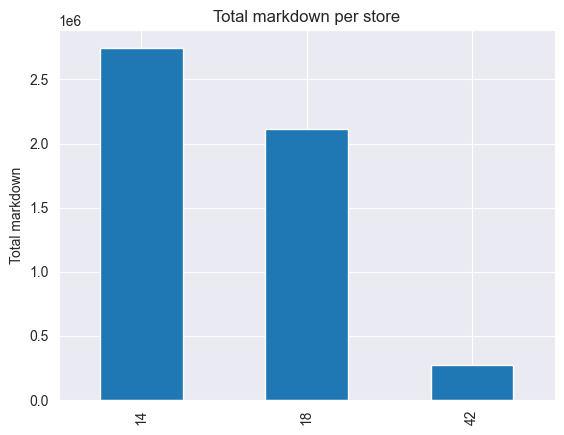

In [24]:
grouped = new_df.groupby('Store')['Total_MarkDown'].sum()
grouped.plot(kind='bar')
plt.xlabel('')
plt.ylabel('Total markdown')
plt.title('Total markdown per store')
plt.show()

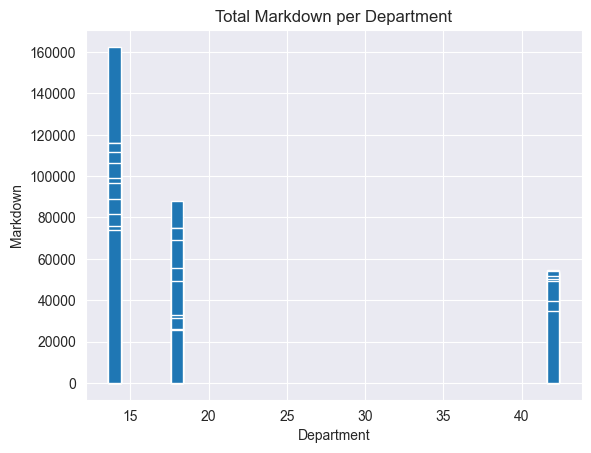

In [25]:
plt.bar(new_df['Store'], new_df['Weekly_Sales'])
plt.title("Total Markdown per Department")
plt.xlabel('Department')
plt.ylabel('Markdown')
plt.show()

In [26]:
new_df['Date'] = pd.to_datetime(new_df['Date'])
new_df['year'] = new_df['Date'].dt.year

df_store_37 = new_df[new_df['Store'].isin([42])]
df_store_37['Date'] = pd.to_datetime(df_store_37['Date'], format('%m-%d-%y'))
df_store_37['Date'] = df_store_37['Date'].dt.strftime('%y-%m-%d')
sns.lineplot(x=df_store_37['Date'], y=df_store_37['Weekly_Sales'], hue=df_store_37['year'])
plt.title("Total Markdown per Department")
plt.xlabel('Department')
plt.ylabel('Markdown')
plt.show()

/var/folders/h6/jcdx533j7414r00pkwz6gynr0000gn/T/ipykernel_5712/4249488140.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_store_37['Date'] = pd.to_datetime(df_store_37['Date'], format('%m-%d-%y'))
/var/folders/h6/jcdx533j7414r00pkwz6gynr0000gn/T/ipykernel_5712/4249488140.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_store_37['Date'] = df_store_37['Date'].dt.strftime('%y-%m-%d')


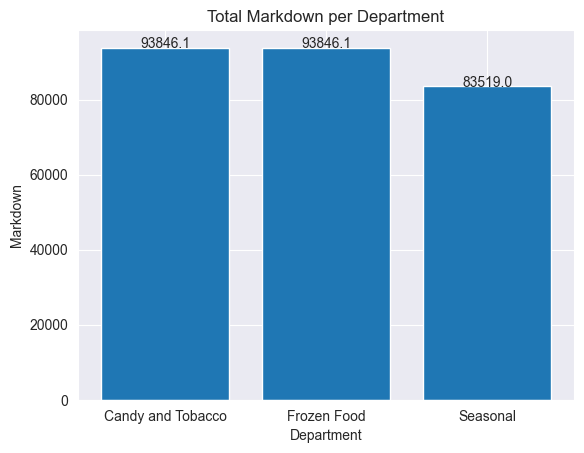

In [27]:
df_store_37 = new_df[new_df['Store'].isin([42])]
grouped = df_store_37.groupby('Description')['Total_MarkDown'].sum()
plt.bar(grouped.index, grouped.values)
plt.title("Total Markdown per Department")
plt.xlabel('Department')
plt.ylabel('Markdown')
for i, value in enumerate(grouped.values):
    plt.text(i, value + 1, str(value), ha='center')

plt.show()

In [28]:
data = new_df
holiday_markdown = data.groupby('HolidayNames')['Total_MarkDown'].sum()

holiday_markdown.plot(kind='bar')
for i, value in enumerate(holiday_markdown.values):
    plt.text(i, value + 1, str(value), ha='center')
plt.show()

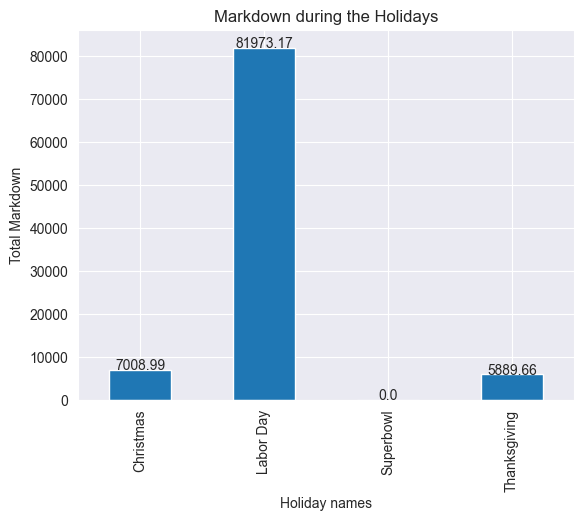

In [29]:
filtered_df = data[data['HolidayNames'] != '-']
grouped = filtered_df.groupby('HolidayNames')['Total_MarkDown'].sum()

grouped.plot(kind='bar')
plt.xlabel('Holiday names') 
plt.ylabel('Total Markdown')
plt.title('Markdown during the Holidays')
for i, value in enumerate(grouped.values):
    plt.text(i, value + 1, str(value), ha='center')
plt.show()

In [30]:
plt.scatter(data['Temperature'], data['Weekly_Sales']) 
plt.xlabel('Weekly Sales') 
plt.ylabel('')
plt.show()

In [31]:
data = new_df
plt.scatter(data['CPI'], data['Weekly_Sales']) 
plt.xlabel('CPI') 
plt.ylabel('Weekly Sales')
plt.show()

print(min(data['CPI']), max(data['CPI']))

126.064 192.3308542


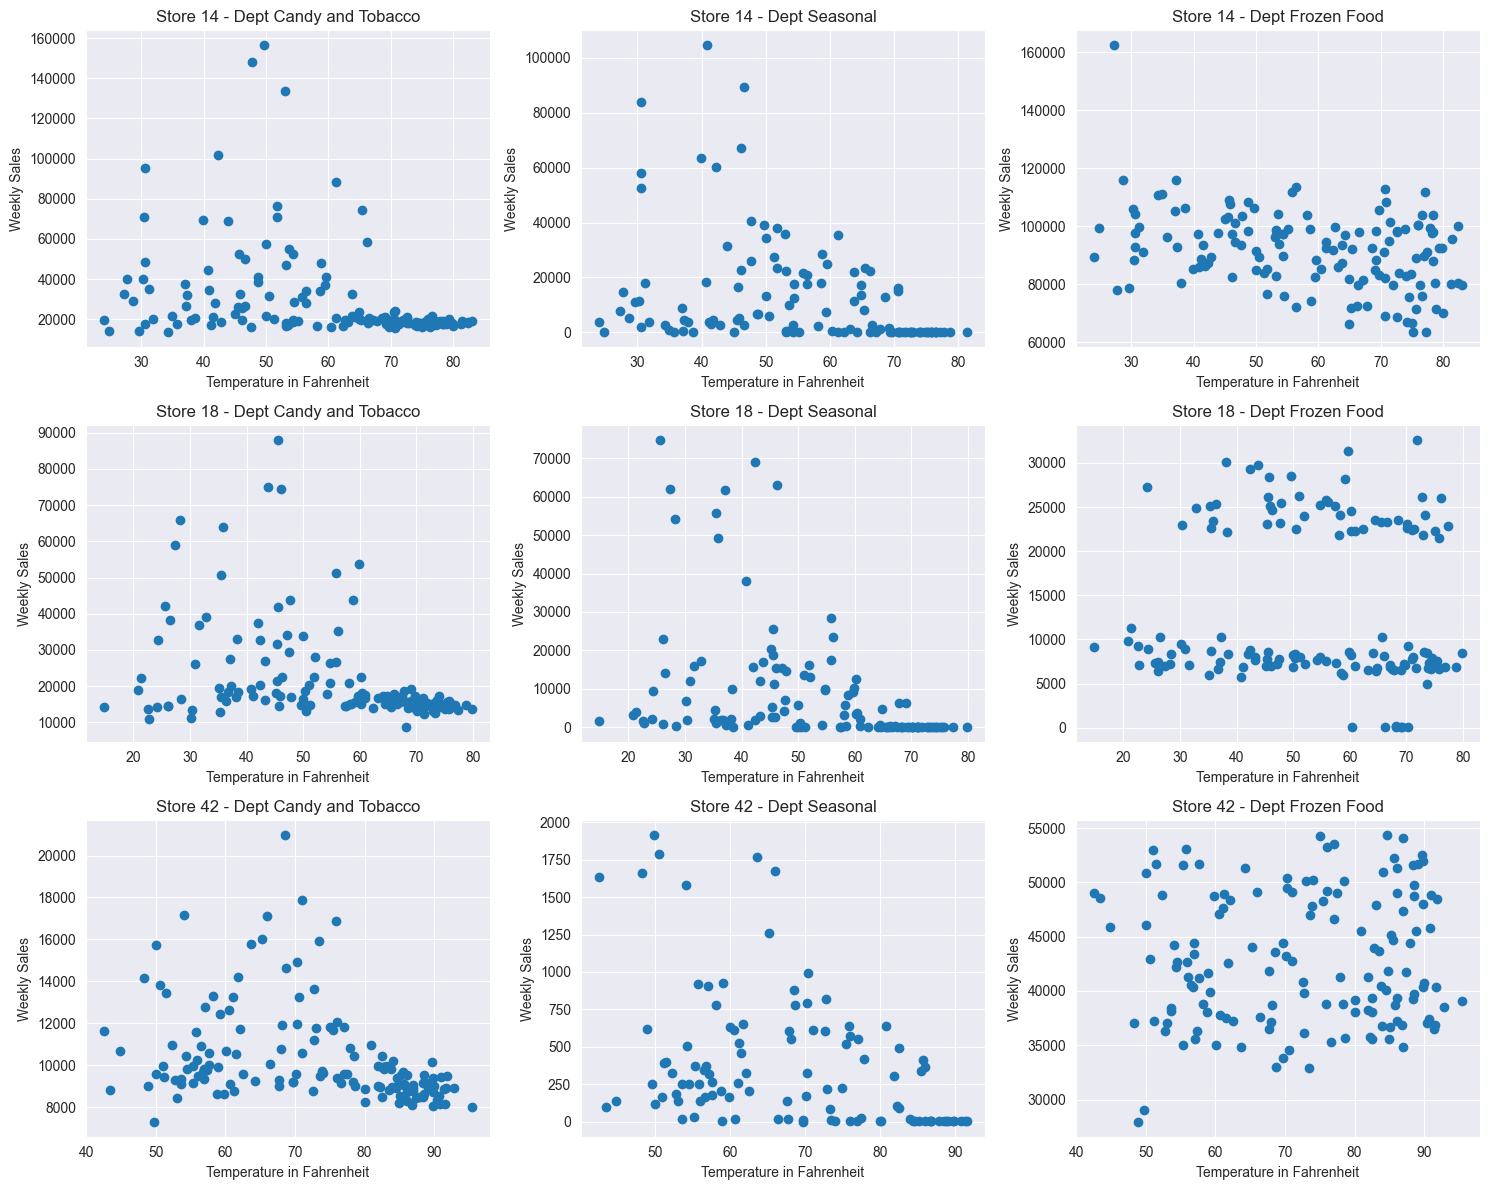

In [32]:
# Get unique store and department combinations from the DataFrame
unique_stores = data['Store'].unique()
unique_dept = data['Description'].unique()

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate through unique store and department combinations
for i, store_id in enumerate(unique_stores):
    for j, dept_id in enumerate(unique_dept):
        # Filter the data for the current store and department
        new_data = data[(data['Store'] == store_id) & (data['Description'] == dept_id)]

        # Plot the data on the corresponding subplot
        axes[i * 3 + j].scatter(new_data['Temperature'], new_data['Weekly_Sales'])
        axes[i * 3 + j].set_xlabel('Temperature in Fahrenheit')
        axes[i * 3 + j].set_ylabel('Weekly Sales')
        axes[i * 3 + j].set_title(f'Store {store_id} - Dept {dept_id}')

# Remove any empty subplots
for k in range(i * 3 + j + 1, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()

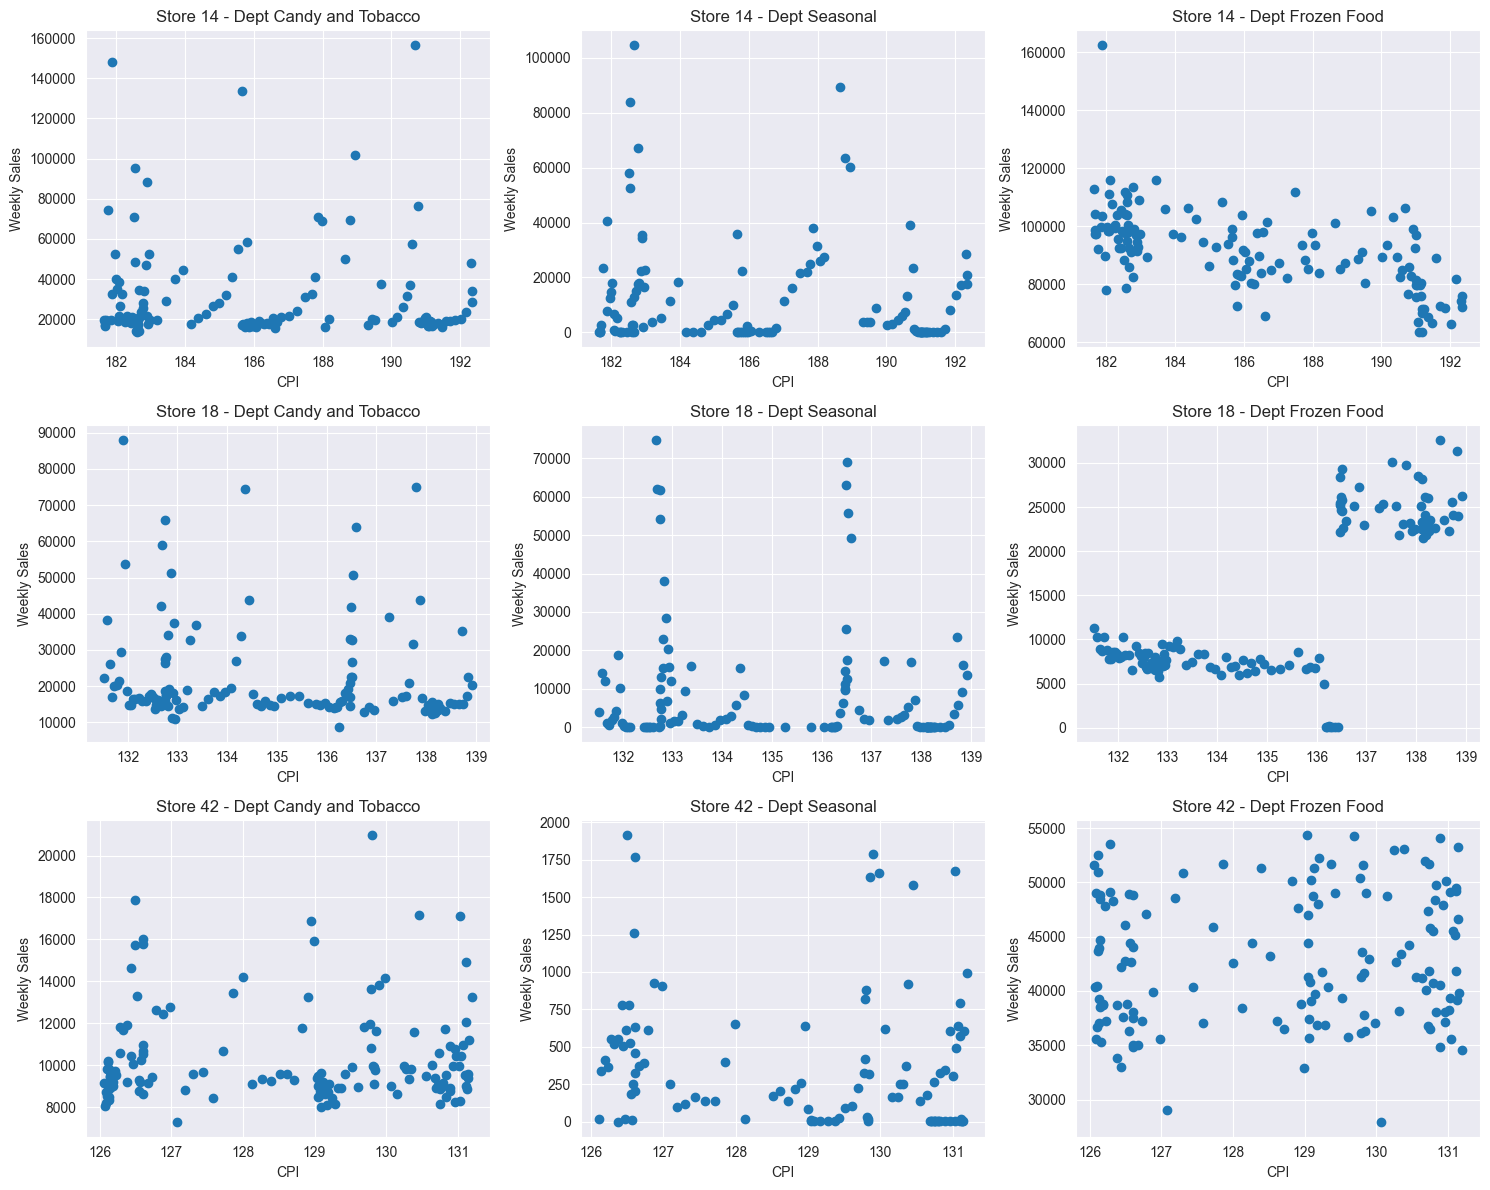

In [33]:
# Get unique store and department combinations from the DataFrame
unique_stores = data['Store'].unique()
unique_dept = data['Description'].unique()

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate through unique store and department combinations
for i, store_id in enumerate(unique_stores):
    for j, dept_id in enumerate(unique_dept):
        # Filter the data for the current store and department
        new_data = data[(data['Store'] == store_id) & (data['Description'] == dept_id)]

        # Plot the data on the corresponding subplot
        axes[i * 3 + j].scatter(new_data['CPI'], new_data['Weekly_Sales'])
        axes[i * 3 + j].set_xlabel('CPI')
        axes[i * 3 + j].set_ylabel('Weekly Sales')
        axes[i * 3 + j].set_title(f'Store {store_id} - Dept {dept_id}')

# Remove any empty subplots
for k in range(i * 3 + j + 1, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()

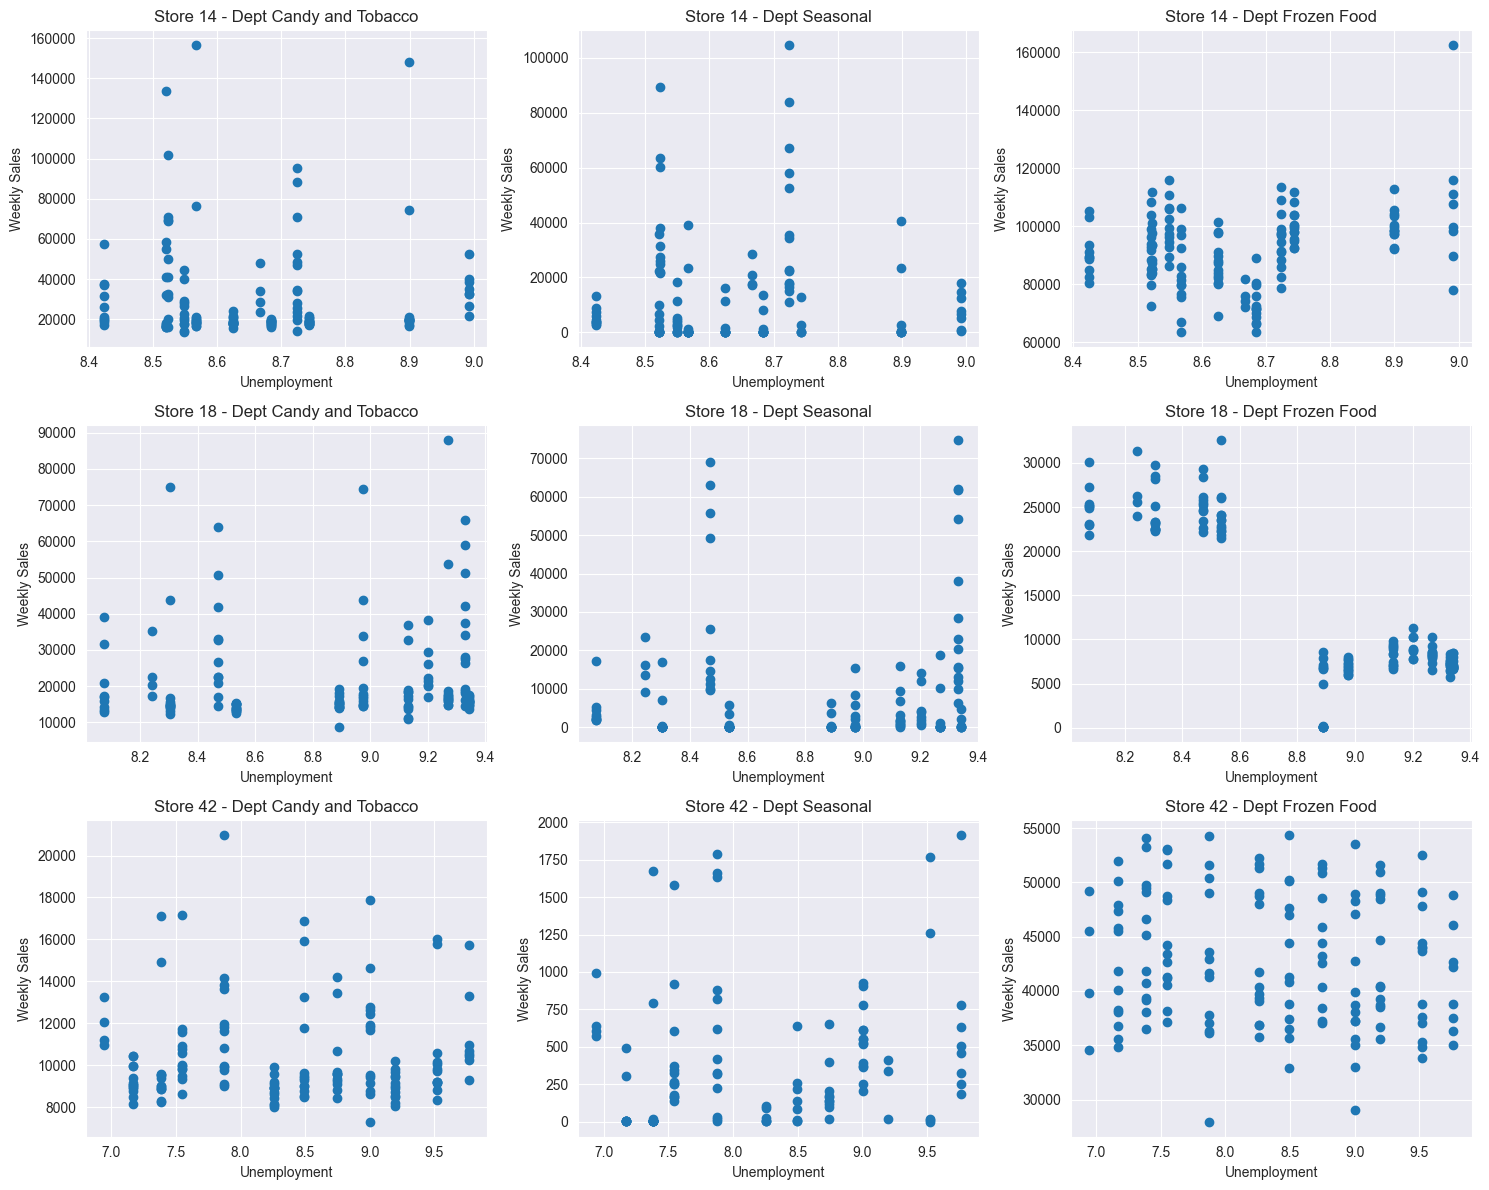

In [34]:
# Get unique store and department combinations from the DataFrame
unique_stores = data['Store'].unique()
unique_dept = data['Description'].unique()

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate through unique store and department combinations
for i, store_id in enumerate(unique_stores):
    for j, dept_id in enumerate(unique_dept):
        # Filter the data for the current store and department
        new_data = data[(data['Store'] == store_id) & (data['Description'] == dept_id)]

        # Plot the data on the corresponding subplot
        axes[i * 3 + j].scatter(new_data['Unemployment'], new_data['Weekly_Sales'])
        axes[i * 3 + j].set_xlabel('Unemployment')
        axes[i * 3 + j].set_ylabel('Weekly Sales')
        axes[i * 3 + j].set_title(f'Store {store_id} - Dept {dept_id}')

# Remove any empty subplots
for k in range(i * 3 + j + 1, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()

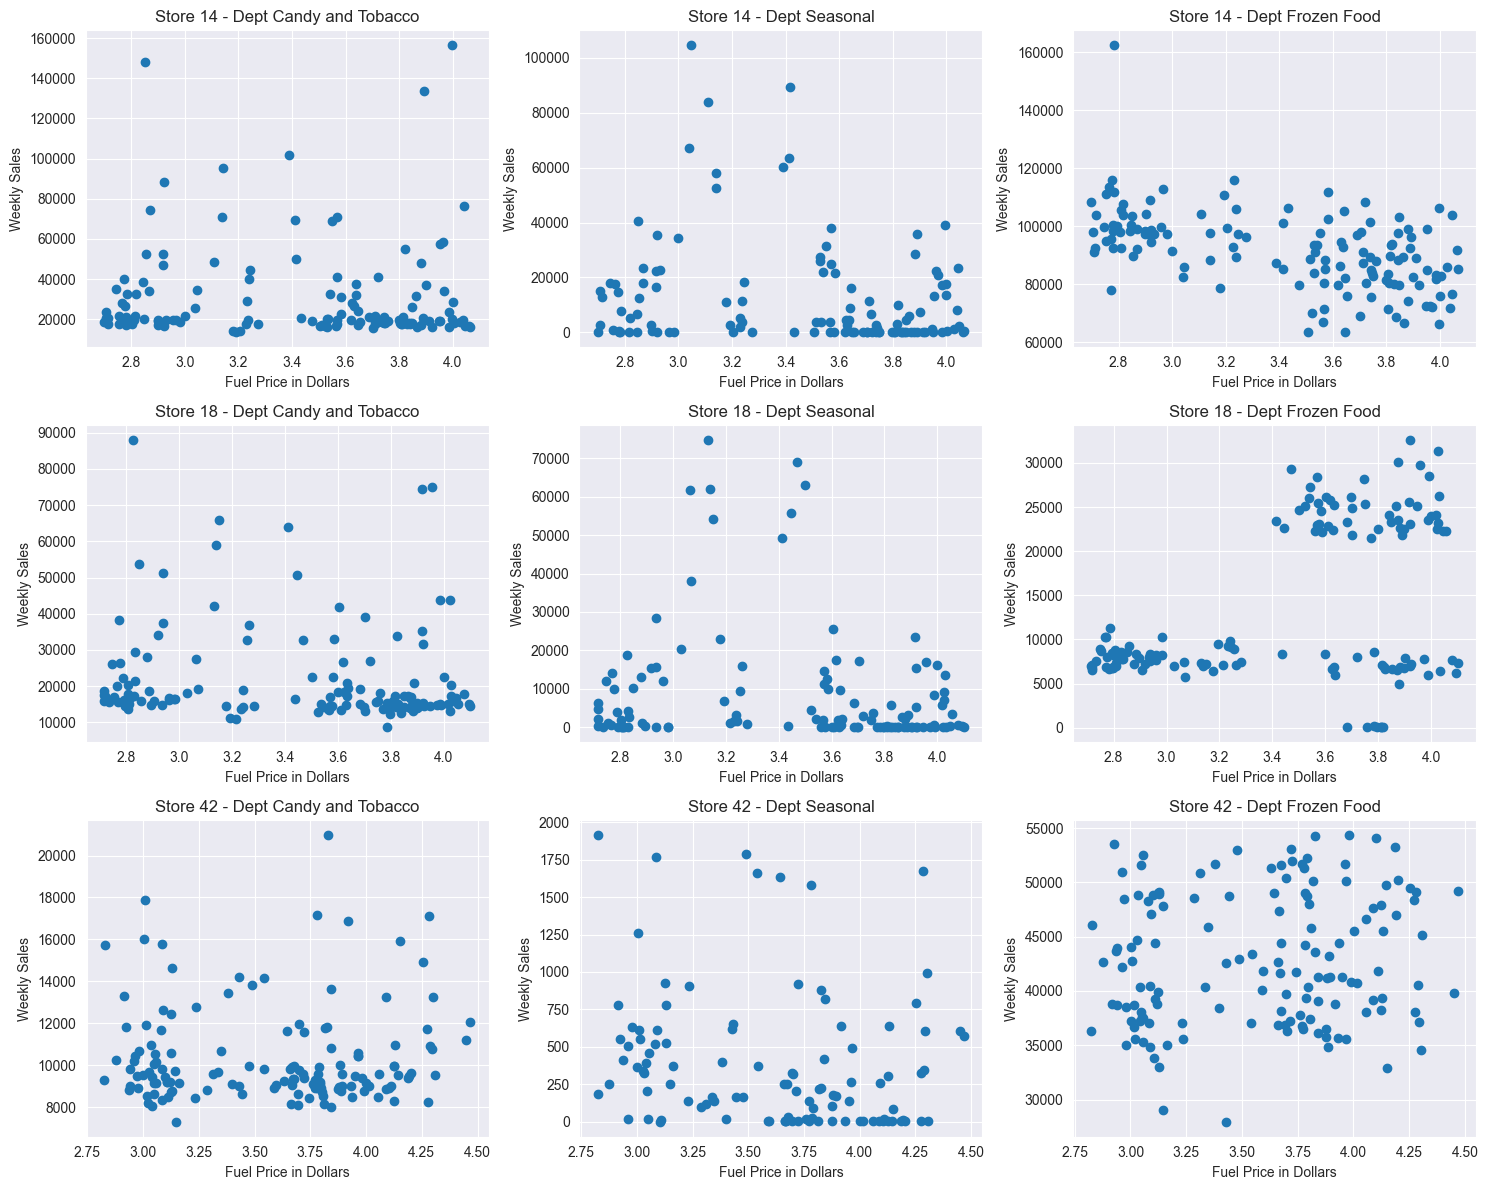

In [35]:
# Get unique store and department combinations from the DataFrame
unique_stores = data['Store'].unique()
unique_dept = data['Description'].unique()

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate through unique store and department combinations
for i, store_id in enumerate(unique_stores):
    for j, dept_id in enumerate(unique_dept):
        # Filter the data for the current store and department
        new_data = data[(data['Store'] == store_id) & (data['Description'] == dept_id)]

        # Plot the data on the corresponding subplot
        axes[i * 3 + j].scatter(new_data['Fuel_Price'], new_data['Weekly_Sales'])
        axes[i * 3 + j].set_xlabel('Fuel Price in Dollars')
        axes[i * 3 + j].set_ylabel('Weekly Sales')
        axes[i * 3 + j].set_title(f'Store {store_id} - Dept {dept_id}')

# Remove any empty subplots
for k in range(i * 3 + j + 1, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()

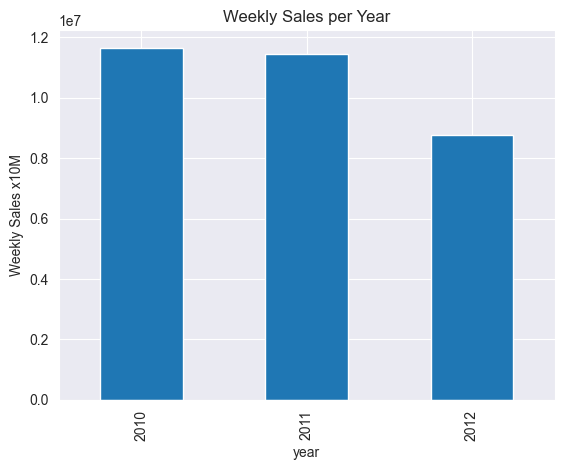

In [36]:
data['Date'] = pd.to_datetime(data['Date'])
data['year'] = data['Date'].dt.year

grouped = data.groupby('year')['Weekly_Sales'].sum()
plt.xlabel('Year')
plt.ylabel('Weekly Sales x10M')
plt.title('Weekly Sales per Year')
grouped.plot(kind='bar')
plt.show()

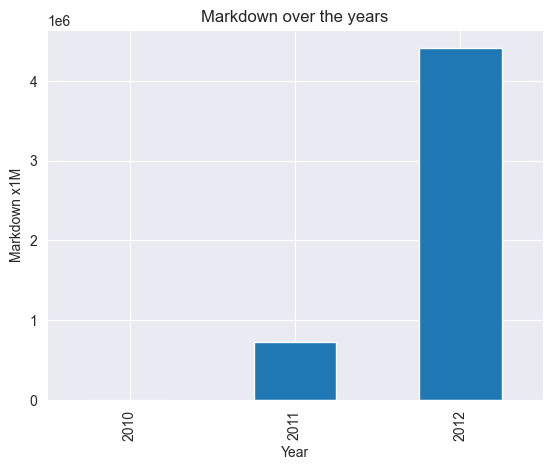

In [37]:
grouped = data.groupby('year')['Total_MarkDown'].sum()
grouped.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Markdown x1M')
plt.title('Markdown over the years')
plt.show()

['-' 'Superbowl' 'Labor Day' 'Thanksgiving' 'Christmas']


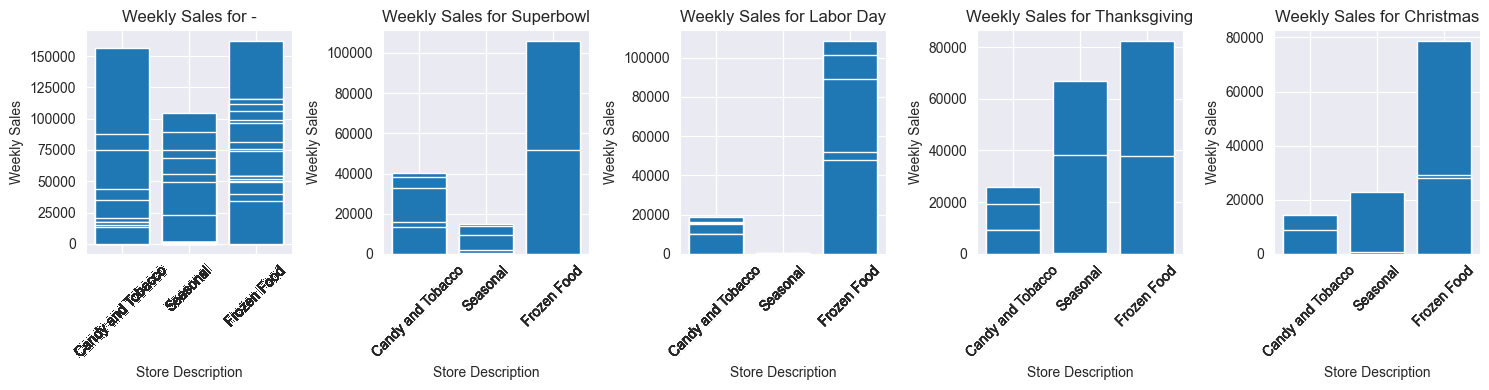

In [38]:
# Get unique holiday names and years from the DataFrame
unique_holidays = data['HolidayNames'].unique()
unique_years = data['year'].unique()

print(unique_holidays)

# Create a grid of subplots with one row and as many columns as there are unique holidays
num_holidays = len(unique_holidays)
fig, axes = plt.subplots(1, num_holidays, figsize=(15, 4))

# Iterate through unique holiday names
for i, holiday_name in enumerate(unique_holidays):
    # Filter the data for the current holiday
    holiday_data = data[data['HolidayNames'] == holiday_name]

    # Plot the weekly sales for the current holiday
    axes[i].bar(holiday_data['Description'], holiday_data['Weekly_Sales'])
    axes[i].set_xlabel('Store Description')
    axes[i].set_ylabel('Weekly Sales')
    axes[i].set_title(f'Weekly Sales for {holiday_name}')
    axes[i].set_xticks(holiday_data['Description'])
    axes[i].set_xticklabels(holiday_data['Description'], rotation=45)  # Adjust rotation angle as needed


plt.tight_layout()
plt.show()

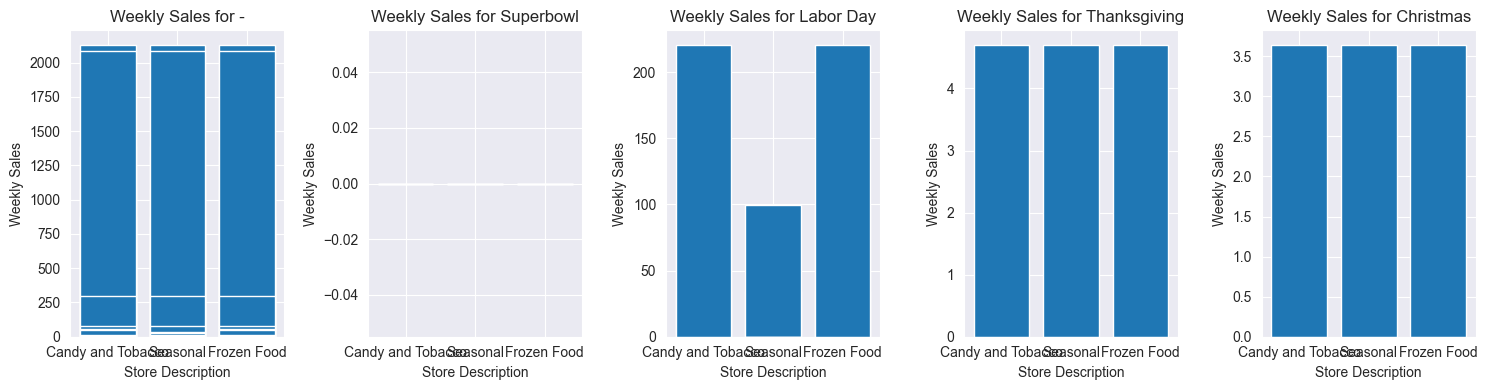

In [39]:
plt.show()
# Get unique holiday names and years from the DataFrame
unique_holidays = data['HolidayNames'].unique()
unique_years = data['year'].unique()

# Create a grid of subplots with one row and as many columns as there are unique holidays
num_holidays = len(unique_holidays)
fig, axes = plt.subplots(1, num_holidays, figsize=(15, 4))

# Iterate through unique holiday names
for i, holiday_name in enumerate(unique_holidays):
    # Filter the data for the current holiday
    holiday_data = data[data['HolidayNames'] == holiday_name]

    # Plot the weekly sales for the current holiday
    axes[i].bar(holiday_data['Description'], holiday_data['MarkDown3'])
    axes[i].set_xlabel('Store Description')
    axes[i].set_ylabel('Weekly Sales')
    axes[i].set_title(f'Weekly Sales for {holiday_name}')
    # axes[i].set_xticks(holiday_data['Description'])
    # axes[i].set_xticklabels(holiday_data['Description'], rotation=45)  # Adjust rotation angle as needed

plt.tight_layout()
plt.show()

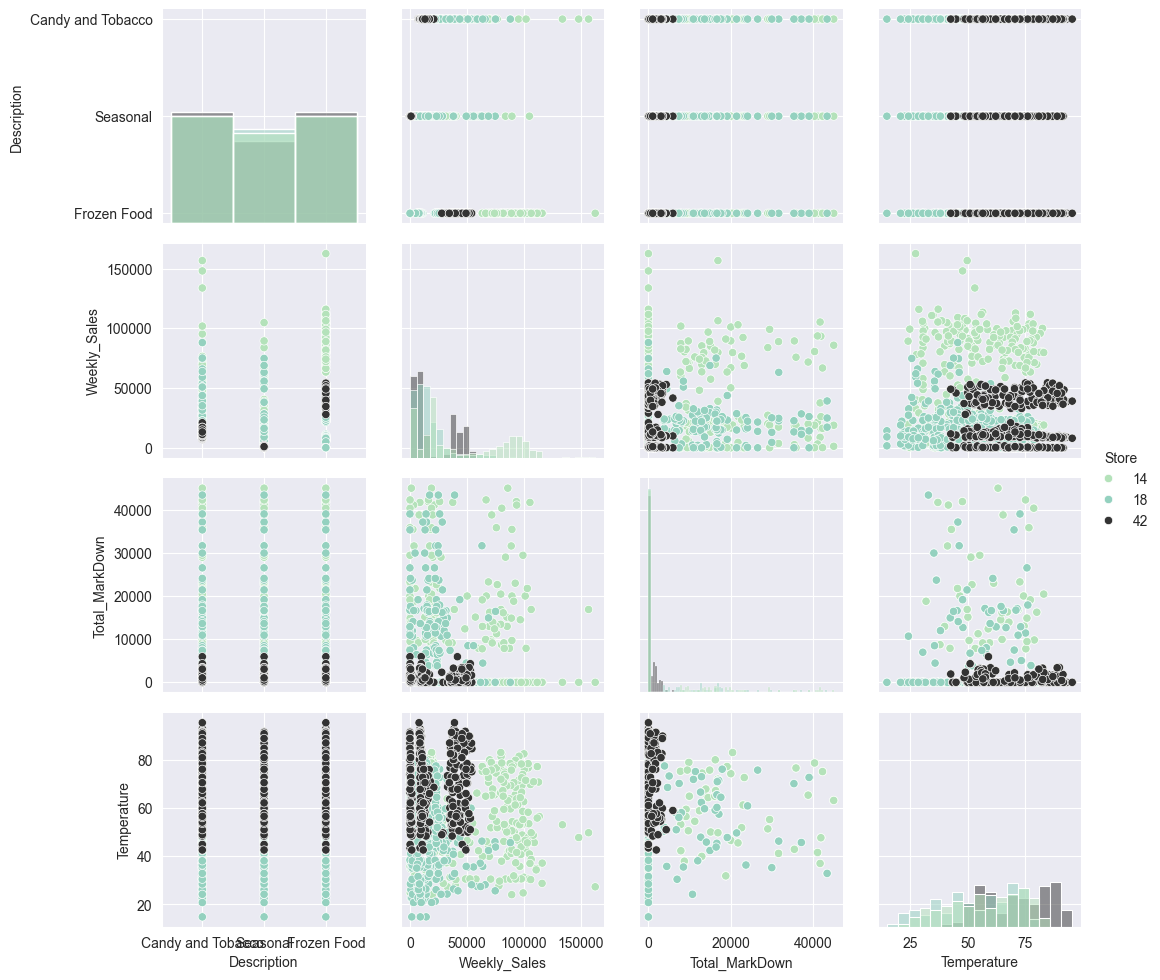

In [40]:
g = sns.PairGrid(data, vars=['Description', 'Weekly_Sales', 'Total_MarkDown', 'Temperature'], hue='Store', palette="GnBu_d")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()